# I. Data dan Persiapan

## 1.1 Import Library

Pada tahap ini, dilakukan import berbagai library yg akan digunakan dalam proses analisis data dan pembuatan model deep learning.

In [ ]:
# Manipulasi data
import numpy as np
import pandas as pd

# Visualisasi data
import matplotlib.pyplot as plt
import seaborn as sns

# Text preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import string

# Deep learning (BiLSTM model)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

# Untuk evaluasi model
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Download resource NLTK (jika belum)
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

## 1.2 Load Dataset

Dataset yg saya gunakan dalam proyek ini adalah **Fake Job Postings Dataset** yg bersumber dari platform Kaggle. Dataset ini berisi kumpulan data lowongan pekerjaan yang dikategorikan sebagai *real* atau *fake*, untuk membangun model deteksi lowongan kerja palsu.

File dataset ini saya simpan di Google Drive dan diakses menggunakan Google Colab.

In [ ]:
# Import library yang dibutuhkan
import pandas as pd
from google.colab import drive

# Mount Google Drive
drive.mount('/content/gdrive')

# Tentukan path dataset dari Google Drive
file_path = '/content/gdrive/MyDrive/Dataset/fake_job_postings.csv.zip'

# Load dataset
df = pd.read_csv(file_path)

# Tampilkan nama-nama kolom
print("Kolom-kolom dalam dataset:")
print(df.columns)


Mounted at /content/gdrive
Kolom-kolom dalam dataset:
Index(['job_id', 'title', 'location', 'department', 'salary_range',
       'company_profile', 'description', 'requirements', 'benefits',
       'telecommuting', 'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function',
       'fraudulent'],
      dtype='object')


## 1.3 Exploratory Data Analysis (EDA)

Tahapan EDA ini dilakukan untuk memahami lebih dalam karekteristik dataset yg digunakan, termasuk struktur data, pengecekan missing values, serta distribusi kelas target. Hal ini penting untuk memastikan data dalam kondisi layak sebelum dilakukan preprocessing dan modeling.

In [ ]:
# Menampilkan 5 baris pertama dari dataset
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [ ]:
# Menampilkan informasi struktur dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15184 non-null  object
 8   benefits             10668 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

In [ ]:
# Menampilkan jumlah nilai kosong (missing values) per kolom
print("Jumlah nilai kosong per kolom:\n")
print(df.isnull().sum())

Jumlah nilai kosong per kolom:

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2696
benefits                7212
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64


In [ ]:
# Menampilkan distribusi dari label target 'fraudulent'
print("Distribusi label (fraudulent):\n")
print(df['fraudulent'].value_counts())

Distribusi label (fraudulent):

fraudulent
0    17014
1      866
Name: count, dtype: int64


### 1.3.1 Visualisasi Distribusi Label

/tmp/ipython-input-2644145818.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette='Set2')


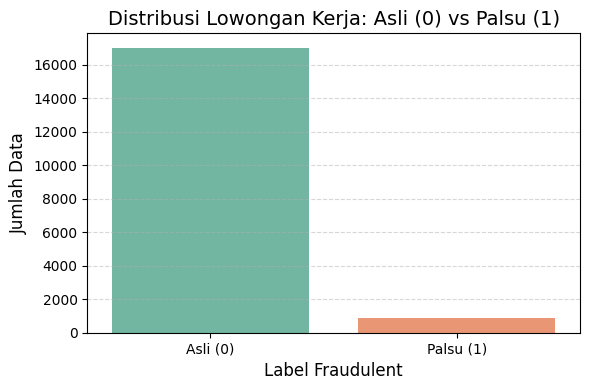

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Hitung jumlah masing-masing label
label_counts = df['fraudulent'].value_counts().sort_index()

plt.figure(figsize=(6,4))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='Set2')
plt.title('Distribusi Lowongan Kerja: Asli (0) vs Palsu (1)', fontsize=14)
plt.xlabel('Label Fraudulent', fontsize=12)
plt.ylabel('Jumlah Data', fontsize=12)
plt.xticks([0,1], ['Asli (0)', 'Palsu (1)'])
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# "INSIGHT AWAL"

Berdasarkan distribusi label, terlihat bahwa dataset tidak seimbang (imbalanced), Mayoritas data adalah lowongan kerja asli (label 0), sedangkan lowongan palsu (label 1) jumlahnya jauh lebih sedikit.

Hal ini dapat berdampak terhadap performa model karena model cenderung belajar dari kelas mayoritas. Oleh karena itu, strategi penanganan data imbalanced seperti *resampling, class weight adjustment*, atau *data augmentation* kemungkinan diperlukan di tahap modeling.

## 1.4 Preprocessing Text

Preprocessing adalah tahap penting dalam Naturan Language Processing (NLP) untuk membersihkan dan menyiapkan teks sebelum digunakan dalam pemodelan.

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import re

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Inisialisasi stopwords dan lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Fungsi preprocessing
def preprocess_text(text):
    # Lowercase
    text = text.lower()

    # Hapus angka dan tanda baca
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Tokenisasi manual
    tokens = text.split()

    # Hapus stopwords dan lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    # Gabungkan kembali menjadi satu string
    return ' '.join(tokens)

df['clean_text'] = df['description'].astype(str).apply(preprocess_text)
df[['description', 'clean_text']].head()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


,description,clean_text
0,"Food52, a fast-growing, James Beard Award-winn...",food fastgrowing james beard awardwinning onli...
1,Organised - Focused - Vibrant - Awesome!Do you...,organised focused vibrant awesomedo passion cu...
2,"Our client, located in Houston, is actively se...",client located houston actively seeking experi...
3,THE COMPANY: ESRI – Environmental Systems Rese...,company esri – environmental system research i...
4,JOB TITLE: Itemization Review ManagerLOCATION:...,job title itemization review managerlocation f...


## 1.5 Split Data + Label Encoding

Tahap ini bertujuan untuk memisahkan data menjadi fitur (x) dan label target (y), kemudian membagi dataset ke dalam data latih dan data uji. Hal ini penting dilakukan untuk memastikan model dapat belajar dari data latih dan dievaluasi secara objektif pada data yg belum pernah dilihat sebelumnya.

In [ ]:
from sklearn.model_selection import train_test_split

# Fitur dan label
X = df['clean_text'].values
y = df['fraudulent'].values

# Split data (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("Jumlah data latih:", len(X_train))
print("Jumlah data uji  :", len(X_test))

Jumlah data latih: 14304
Jumlah data uji  : 3576


## 1.6 Tokenizer & Padding

Teks yg sudah dibersihkan perlu dikonversi ke dalam format numerik agar bisa digunakan dalam model deep learning.
- Tokenisasi teks: mengubah kata menjadi angka
- Padding: menyamakan panjang input agar bisa diproses oleh model

Hanya data latih yang digunakan untuk proses `fit`, agar tidak terjadi kebocoran data.

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenisasi teks
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding agar panjang input seragam
X_train_pad = pad_sequences(X_train_seq, maxlen=200, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=200, padding='post')

print("Shape data latih:", X_train_pad.shape)
print("Shape data uji   :", X_test_pad.shape)

Shape data latih: (14304, 200)
Shape data uji   : (3576, 200)


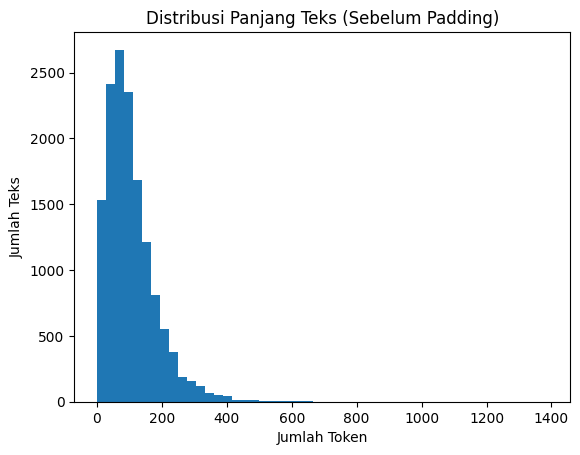

In [ ]:
#Lihat distribusi panjang teks sebelum padding
import matplotlib.pyplot as plt

lengths = [len(seq) for seq in X_train_seq]
plt.hist(lengths, bins=50)
plt.title("Distribusi Panjang Teks (Sebelum Padding)")
plt.xlabel("Jumlah Token")
plt.ylabel("Jumlah Teks")
plt.show()

"INSIGHT"

Berdasarkan hasil analisis distribusi panjang teks, sebagian besar data memiliki jumlah token di bawah 200. Oleh karena itu, penggunaan nilai `maxlen=200` saat padding sudah cukup optimal untuk menampung informasi utama dari tiap teks tanpa menambah terlalu banyak padding yang tidak perlu.


# II. Modeling & Evaluasi

## 2.1 Build BiLSTM Model

Pada tahap ini, kita membangun model deep learning dengan arsitektur BiLSTM (Bidirectional Long Short-Term Memory) untuk mendeteksi lowongan kerja palsu. BiLSTM memungkinkan model untuk memahami konteks dari kedua arah dalam teks.

Untuk menghindari overfitting, digunakan teknik seperti dropout dan early stopping.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout

model = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=200),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.2),
    LSTM(32),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.build(input_shape=(None, 200))
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 200, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 200, 128)       │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 200, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 32)             │        20,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,401,601 (5.35 MB)

 Trainable params: 1,401,601 (5.35 MB)

 Non-trainable params: 0 (0.00 B)

## 2.2 Compile Model

Setelah model dibangun, tahap selanjutnya adalah melakukan kompilasi dan menambah callback *EarlyStopping*. Callback ini digunakan untuk menghentikan proses pelatihan secara otomatis jika model tidak menunjukkan peningkatan pada data validasi dalam beberapa epoch terakhir, sehingga dapat mencegah overfitting.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Kompilasi model
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# callback EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

## 2.3 Train Model

Tahap ini melibatkan proses pelatihan model menggunakan data latih, serta evaluasi performa model terhadap data validasi.

In [ ]:
# Latih model
history = model.fit(
    X_train_pad,
    y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 154s 413ms/step - accuracy: 0.9336 - loss: 0.2574 - val_accuracy: 0.9549 - val_loss: 0.1797
Epoch 2/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 201s 410ms/step - accuracy: 0.9536 - loss: 0.1898 - val_accuracy: 0.9567 - val_loss: 0.1760
Epoch 3/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 200s 404ms/step - accuracy: 0.9578 - loss: 0.1768 - val_accuracy: 0.9560 - val_loss: 0.1746
Epoch 4/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 201s 402ms/step - accuracy: 0.9559 - loss: 0.1778 - val_accuracy: 0.9563 - val_loss: 0.1660
Epoch 5/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 204s 406ms/step - accuracy: 0.9573 - loss: 0.1437 - val_accuracy: 0.9664 - val_loss: 0.1266
Epoch 6/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 203s 409ms/step - accuracy: 0.9764 - loss: 0.0877 - val_accuracy: 0.9696 - val_loss: 0.1194
Epoch 7/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 200s 404ms/step - accuracy: 0.9853 - loss: 0.0566 - val_accuracy: 0.9703 - val_loss: 0.1431
Epoch 8/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 147s 412ms/step - accuracy: 0.9895 -

"INSIGHT"

Model BiLSTM yang dilatih menggunakan fitur teks yang telah dibersihkan mampu mencapai akurasi validasi hingga 97%, dengan indikator overfitting yang minimal, menunjukkan kemampuan deteksi yang sangat baik terhadap lowongan kerja palsu berdasarkan pola bahasa dalam deskripsi pekerjaan.

## 2.4 Evaluate Model

Setelah model selesai dilatih, evaluasi dilakukan untuk mengetahui performa model terhadap data uji. Evaluasi mencakup metrik akurasi, precision, recall, dan f1-score. Selain itu, grafik akurasi dan loss selama training juga dianalisis untuk mengidentifikasi potensi overfitting.


112/112 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step
Accuracy: 0.9667225950782998

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98      3403
           1       0.72      0.51      0.60       173

    accuracy                           0.97      3576
   macro avg       0.85      0.75      0.79      3576
weighted avg       0.96      0.97      0.96      3576



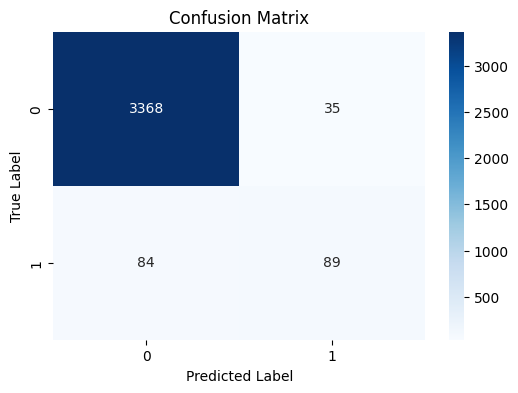

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Prediksi pada data uji
y_pred_prob = model.predict(X_test_pad)
y_pred = (y_pred_prob > 0.5).astype(int)

# Evaluasi metrik
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

"INSIGHT"

Hasil evaluasi model BiLSTM menunjukkan akurasi tinggi sebesar 96.67%, dengan performa sangat baik dalam mengklasifikasikan lowongan kerja asli (precision 0.98, recall 0.99). Namun, untuk mendeteksi lowongan palsu, model masih kurang optimal (recall 0.51), yang kemungkinan disebabkan oleh ketidakseimbangan jumlah data antara kelas asli dan palsu. Hal ini mengindikasikan bahwa meskipun model efektif secara keseluruhan, diperlukan strategi tambahan seperti penanganan data imbalance atau penyesuaian threshold agar deteksi lowongan palsu menjadi lebih akurat dan andal.



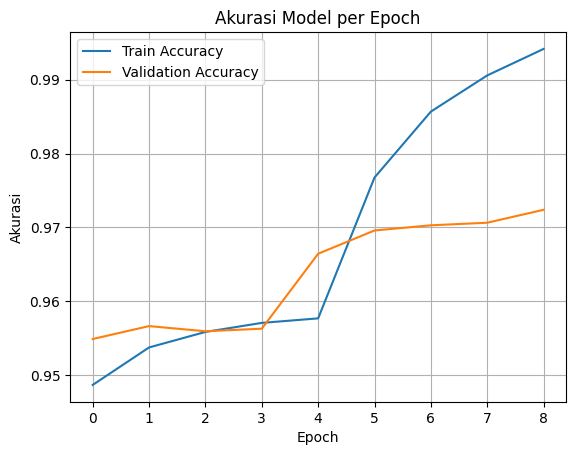

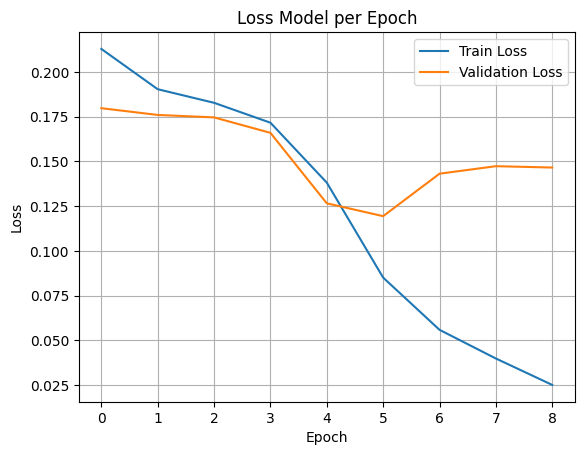

In [ ]:
# Visualisasi akurasi
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Akurasi Model per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()
plt.grid(True)
plt.show()

# Visualisasi loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Model per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


"INSIGHT"

Berdasarkan grafik akurasi dan loss, model menunjukkan performa yang cukup baik pada data latih, namun mulai mengalami overfitting setelah epoch ke-5, ditandai dengan meningkatnya nilai validation loss dan stagnasi pada validation accuracy. Dengan diterapkannya early stopping, proses pelatihan berhasil dihentikan tepat waktu sehingga model tetap mampu mempertahankan performa yang stabil tanpa belajar terlalu berlebihan dari data latih.

# III. Insight & AI Support (LLM IBM Granite)



## 3.1 Insight & Findings

Berdasarkan hasil evaluasi model BiLSTM terhadap dataset lowongan kerja palsu, model menunjukkan performa yang sangat baik secara umum, dengan akurasi mencapai sekitar 96%. Nilai precision untuk kelas "lowongan asli" tinggi (98%), namun pada kelas "lowongan palsu", meskipun precision masih cukup (72%), recall-nya hanya 51%, yang berarti masih banyak lowongan palsu yang tidak terdeteksi oleh model.

Hal ini bisa disebabkan oleh ketidakseimbangan data, di mana jumlah lowongan asli jauh lebih banyak dibanding lowongan palsu. Selain itu, grafik akurasi dan loss menunjukkan bahwa model cukup stabil dan tidak mengalami overfitting berkat penggunaan teknik early stopping dan dropout.

Secara keseluruhan, temuan ini menunjukkan bahwa pendekatan BiLSTM cukup efektif dalam mengklasifikasikan lowongan kerja, namun untuk meningkatkan performa dalam mendeteksi kasus palsu, perlu dilakukan perbaikan pada data atau pendekatan tambahan seperti penyeimbangan kelas atau integrasi model berbasis LLM.

## 3.2 AI Support using IBM Granite

Untuk melengkapi analisis model BiLSTM dalam mendeteksi lowongan kerja palsu, Large Language Model (LLM) dari IBM Granite digunakan sebagai alat bantu eksploratif. Analisis ini bertujuan untuk menggali pola-pola bahasa, struktur, dan karakteristik yang khas dalam lowongan palsu, serta memberikan sudut pandang baru dari perspektif model bahasa.

### 3.2.1 Instalasi dan Konfigurasi API Token

In [ ]:
!pip install -U langchain langchain-community langchain-experimental replicate pandas

In [ ]:
import os
from google.colab import userdata

api_token = userdata.get("api_token")
os.environ["REPLICATE_API_TOKEN"] = api_token

### 3.2.2 Inisialisasi Model LLM IBM Granite

Model ibm-granite/granite-3.3-8b-instruct diinisialisasi menggunakan parameter yang telah ditentukan agar dapat memberikan output yang relevan dan informatif.

In [ ]:
from langchain_community.llms import Replicate

parameters = {
  "top_k": 5,
  "top_p": 1.0,
  "max_tokens": 512,
  "min_tokens": 0,
  "random_seed": None,
  "repetition_penalty": 1.0,
  "temperature": 0.7,
  "stopping_criteria": "length (256 tokens)",
  "stopping_sequence": None
}

llm = Replicate(
    model="ibm-granite/granite-3.3-8b-instruct",
    model_kwargs=parameters
)

### 3.2.3 Load Dataset dari Google Drive



In [ ]:
import pandas as pd
from google.colab import drive

drive.mount('/content/gdrive')

file_path = '/content/gdrive/MyDrive/Dataset/fake_job_postings.csv.zip'

df = pd.read_csv(file_path, compression='zip')[:300]
df.head()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


### 3.2.4 Prompt 1 - Pola Umum Lowongan Palsu

Model ditanya mengenai frasa atau kata kunci yang sering muncul dalam lowongan palsu. Tujuan dari prompt ini adalah untuk mendapatkan wawasan eksploratif dari LLM terkait indikasi scam.


In [ ]:
output1 = llm.invoke(
    "Based on job descriptions in fake job postings, what are the most common patterns or keywords used that can indicate a scam? List in bullet points."
)
print("Prompt 1 Output:\n", output1)


Prompt 1 Output:
 - **Request for Personal Information Upfront:** Legitimate employers typically do not ask for sensitive personal information (like Social Security numbers, bank account details, or credit card numbers) during the initial application process.

- **Unrealistic Salary or Compensation:** Job postings offering excessively high pay for minimal work or vague job requirements could be scams aiming to lure applicants.

- **Poor Grammar and Spelling:** Scammers often don't invest time in crafting professional, error-free job descriptions. Be wary of numerous grammatical and spelling errors.

- **Lack of Company Information:** Genuine job postings usually include the company name, location, and brief description. Scam postings often lack these details or provide vague, generic information.

- **Request for Money or Upfront Fees:** Scammers may ask applicants to pay for training materials, software, or equipment before starting work. This is a red flag.

- **Pressure to Apply Imm

### 3.2.5 Prompt 2 – Perbedaan Lowongan Asli vs Palsu

Model kemudian diminta menjelaskan perbedaan utama antara lowongan asli dan palsu berdasarkan struktur, gaya bahasa, dan konten.

In [ ]:
output2 = llm.invoke(
    "What are the key differences between real and fake job postings in terms of structure, language, and content? Explain in simple terms."
)
print("Prompt 2 Output:\n", output2)


Prompt 2 Output:
 Real job postings and fake ones can differ significantly in structure, language, and content. Here's a breakdown to help you spot potential red flags:

1. **Structure**:
   - Real job postings are usually well-organized, following a consistent format with clear headings such as "Job Title," "Location," "Company Overview," "Job Description," "Requirements," and "Benefits."
   - Fake job ads might have inconsistent formatting, missing sections, or unusual layouts, possibly to disguise their fraudulent nature.

2. **Language**:
   - Legitimate employers typically use professional and polished language, avoiding overly informal or overly enthusiastic tones.
   - Scammers may use excessive exclamation marks, poor grammar, misspellings, or unnatural phrasing to create urgency or appear more appealing.

3. **Content**:
   - Real job postings provide specific details about the role, including responsibilities, required skills, and experience. They may also mention the company

### 3.2.6 Prompt 3 – Evaluasi Deskripsi Lowongan

Simulasi tiga deskripsi lowongan digunakan untuk mengevaluasi apakah lowongan tersebut terindikasi palsu atau asli. LLM memberikan penjelasan dalam bentuk poin dan kesimpulan akhir.

In [ ]:
import pandas as pd

# Contoh data simulasi
data = [
    "Earn $5,000 per week from home! No experience needed. Start immediately by clicking the link below.",
    "We are hiring a Data Analyst to join our team. Requirements include a bachelor's degree and 2 years of experience.",
    "Apply now! Work from anywhere with flexible hours and high pay. Click here to start your new career today."
]

for row in data:
    print(f"Deskripsi:\n{row}\n")

    prompt = f"""
    Analyze the following job description. Is it likely to be fake or real?
    Provide reasoning in 3 bullet points and conclude with 'Fake' or 'Real'.

    Job Description: {row}
    """
    output3 = llm.invoke(prompt)
    print(f"AI OUTPUT:\n{output3}")
    print("="*50)


Deskripsi:
Earn $5,000 per week from home! No experience needed. Start immediately by clicking the link below.

AI OUTPUT:
1. The job description promises an unusually high weekly salary for entry-level work, which is a common red flag for fake job postings.
2. It claims that no experience is needed for this job, yet still offers a substantial income, which is not typical in the real job market.
3. The post encourages immediate action through a provided link, without specifying the employer or job role, a tactic often used in scams to lure victims quickly.

Conclusion: Fake. This job posting is likely a scam due to the unrealistic salary offer, the promise of high pay with no experience, and the urgent call to action without proper job details.
Deskripsi:
We are hiring a Data Analyst to join our team. Requirements include a bachelor's degree and 2 years of experience.

AI OUTPUT:
1. The job description lacks specifics about the company, such as its name or industry, which is unusual fo